In [ ]:
from pathlib import Path
import geopandas as gpd
from failure_analysis_functions import cluster_connected,aggregate_clusters_to_points

region_list = ["Achterhoek"]

for region in region_list:
    print(f"Processing region: {region} network")
    root_dir = Path(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Outputs")
    network_file = root_dir / "base_network_hazard.gpkg"
    flood_map = Path(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Inputs\static\*.tif")


Processing region: Achterhoek network


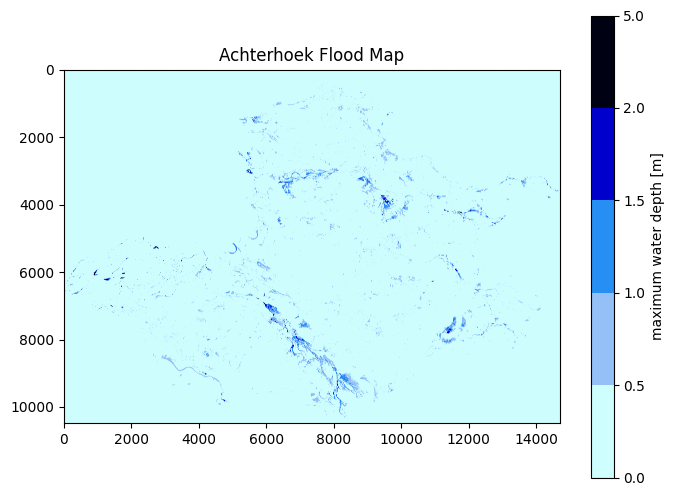

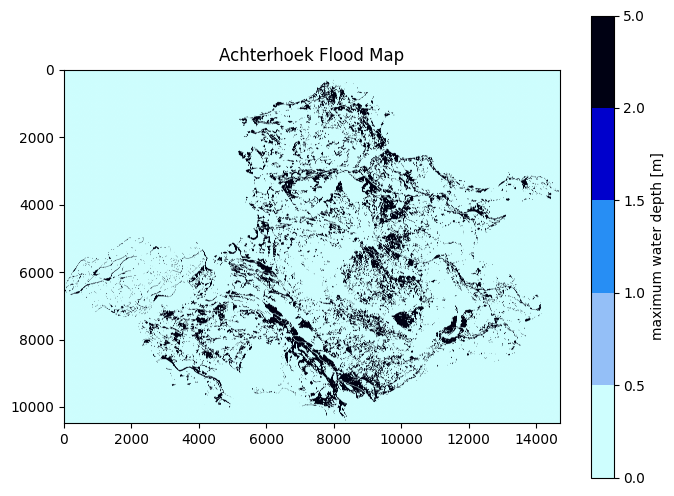

In [ ]:
import matplotlib.colors as mcolors

cbar_label = 'maximum water depth [m]'
vmin = 0
vmax = 5
levels = [vmin, 0.5, 1, 1.5, 2, vmax]
colors = ["#cefefe00",'#94bff7','#278ef4','#0000cc',"#080564","#000113"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, cmap.N)

region_list = ["Achterhoek"]

for region in region_list:
    print(f"Processing region: {region} network")
    root_dir = Path(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Outputs")
    network_file = root_dir / "base_network_hazard.gpkg"
    flood_map_files = glob.glob(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Inputs\static\hazard\*.tif")
    for flood_map_file in flood_map_files:
        with rasterio.open(flood_map_file) as src:
            flood_data = src.read(1)
            plt.figure(figsize=(8,6))
            im = plt.imshow(flood_data, cmap=cmap, norm=norm)
            plt.colorbar(im, label=cbar_label)
            plt.title(f"{region} Flood Map")
            plt.axis('off')
            plt.show()
            

In [ ]:
def aggregate_sections(network_gdf, column, agg_method='mean'):
    """
    Dissolves segments based on the specified column and aggregates EV columns using the specified method.

    Parameters:
        network_gdf (GeoDataFrame): Input GeoDataFrame with 'id_NWB' and EV columns.
        column (str): Column name to dissolve by.
        agg_method (str): Aggregation method: 'mean', 'median', 'min', or 'max'.

    Returns:
        GeoDataFrame: Aggregated GeoDataFrame.
    """
    import numpy as np

    # Select EV columns automatically
    ev_columns = [col for col in network_gdf.columns if col.startswith('EV')]

    agg_funcs = {
        'mean': np.mean,
        'median': np.median,
        'min': np.min,
        'max': np.max
    }
    if agg_method not in agg_funcs:
        raise ValueError("agg_method must be one of: 'mean', 'median', 'min', 'max'")

    agg_dict = {col: agg_funcs[agg_method] for col in ev_columns}

    # Dissolve by 'id_NWB' and aggregate EV columns
    aggregated_gdf = network_gdf.dissolve(by=column, aggfunc=agg_dict)
    aggregated_gdf = aggregated_gdf.reset_index()  # Restore id_NWB as a column

    return aggregated_gdf

Processing region: Limburg
Processing region: Limburg network


CPLE_AppDefinedError: b"sqlite3_exec(UPDATE gpkg_contents SET last_change = strftime('%Y-%m-%dT%H:%M:%fZ','now') WHERE lower(table_name) = lower('aggregated_network_toNWB')) failed: unable to open database file"

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona\_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b"sqlite3_exec(UPDATE gpkg_contents SET last_change = strftime('%Y-%m-%dT%H:%M:%fZ','now') WHERE lower(table_name) = lower('aggregated_network_toNWB')) failed: unable to open database file"


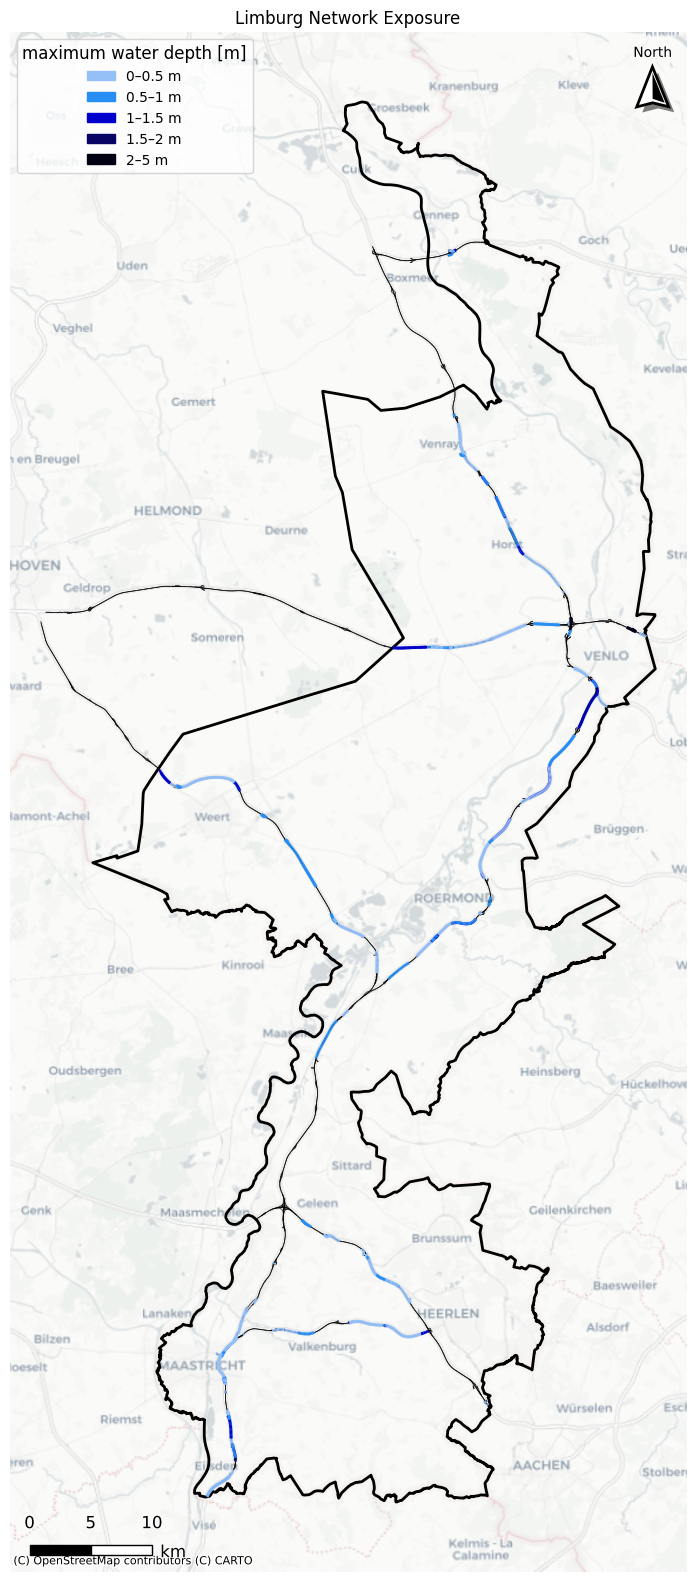

In [90]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import contextily as ctx

from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow
from matplotlib_map_utils.core.scale_bar import ScaleBar, scale_bar


region_list = ["Limburg"]
cbar_label = 'maximum water depth [m]'
vmin = 0
vmax = 5
levels = [vmin, 0.5, 1, 1.5, 2, vmax]
colors = ["#cefefe00",'#94bff7','#278ef4','#0000cc',"#080564","#000113"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(levels, cmap.N)

# Create legend handles
labels = [
    "0–0.5 m",
    "0.5–1 m",
    "1–1.5 m",
    "1.5–2 m",
    "2–5 m"
]
legend_handles = [
    mpatches.Patch(color=colors[i+1], label=labels[i]) for i in range(len(labels))
]

for region in region_list:
    region_shapefile = Path(r"P:\bovenregionale-stresstest-hwn\Data\Hazard_maps\Gebiedsindeling obv waterschappen EXPORT 4dec24.gpkg")
    region_gdf = gpd.read_file(region_shapefile)
    filtered_region = region_gdf[region_gdf['name'] == region]
    print(f"Processing region: {region}")
    print(f"Processing region: {region} network")
    root_dir = Path(rf"P:\bovenregionale-stresstest-hwn\Analysis\{region}\Outputs")
    network_file = root_dir / "base_network_hazard.gpkg"
    network_file_base = gpd.read_file(network_file)
    network_gdf = gpd.read_file(network_file)

    aggregated = aggregate_sections(network_gdf, column='id_NWB', agg_method='mean')
    aggregated.to_file(root_dir / "aggregated_network_toNWB.gpkg", driver='GPKG')

    filtered_region_28992 = filtered_region.to_crs(epsg=28992)
    network_gdf = network_gdf.to_crs(epsg=28992)

    fig, ax = plt.subplots(figsize=(15, 20))
    filtered_region_28992.boundary.plot(ax=ax, color='black', linewidth=2)  
    network_file_base.plot(ax=ax, color='black', linewidth=0.5) 
    aggregated.plot(
        ax=ax, column='EV1_ma', cmap=cmap, norm=norm, markersize=10, legend=False,linewidth=2
    )
    ctx.add_basemap(ax, crs='EPSG:28992',source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    plt.title(f"{region} Network Exposure")

    # Add custom legend instead of colorbar
    ax.legend(handles=legend_handles, title=cbar_label, loc='upper left', fontsize=10, title_fontsize=12)

    north_arrow(
        ax, location="upper right", rotation={"crs": "EPSG:28992", "reference": "center"},
        scale=0.4,
        base={"edgecolor": "black", "linewidth": 2},
        label={"position": "top", "text": "North", "fontsize": 10}
    )

    # Add stepped scale bar with white background
    scalebar = scale_bar(
        ax, location="lower left", style="boxes", bar={"projection": "EPSG:28992","unit": "km"},
    )

    plt.show()